In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import optuna

# To view the entire dataframe
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# Optuna Logging
import optuna.logging
optuna.logging.set_verbosity(optuna.logging.WARNING) # To disable displaying trial results in hyperparameter tuning

In [2]:
borough = "Staten Island" # "Manhattan" "Brooklyn" "Queens" "Staten Island" "Bronx" "EWR"
filename = rf"../../data/with_feature_engineering_totaled/{borough} - all txns.parquet.gz" #
df = pd.read_parquet(filename)

# Get the feature column
target_col = "num_txns_All"
df.head()

,txn_date,quarter,month,day_of_month,txn_hour,week_day,is_weekend,is_monday,is_friday,is_holiday,is_holiday_next_day,is_holiday_previous_day,is_long_weekend,is_rush_hour,is_business_hour,is_night_hour,sin_hour,cos_hour,num_txns_All,lag_24,lag_25,lag_26,lag_27,lag_28,lag_29,lag_30,lag_31,lag_32,lag_33,lag_34,lag_35,lag_36,lag_37,lag_38,lag_39,lag_40,lag_41,lag_42,lag_43,lag_44,lag_45,lag_46,lag_47,lag_48,lag_72,lag_96,lag_120,lag_144,lag_164,lag_165,lag_166,lag_167,lag_168,lag_169,lag_68,lag_69,lag_70,lag_71,lag_73,lag_139,lag_140,lag_141,lag_142,lag_143,lag_145,rolling_avg_24_48_72_lags,std_24_48_72_lags,rolling_avg_w1-w4_lags,std_w1-w4_lags
timestamp_hour,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2019-02-01 00:00:00,2019-02-01,1,2,1,0,5,1,0,0,0,0.0,0.0,0,0,0,1,0.000000,1.000000,29137,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-02-01 01:00:00,2019-02-01,1,2,1,1,5,1,0,0,0,0.0,0.0,0,0,0,1,0.258819,0.965926,17133,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-02-01 02:00:00,2019-02-01,1,2,1,2,5,1,0,0,0,0.0,0.0,0,0,0,1,0.500000,0.866025,10858,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-02-01 03:00:00,2019-02-01,1,2,1,3,5,1,0,0,0,0.0,0.0,0,0,0,1,0.707107,0.707107,8383,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-02-01 04:00:00,2019-02-01,1,2,1,4,5,1,0,0,0,0.0,0.0,0,0,0,1,0.866025,0.500000,9226,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Evaluation helper function

In [8]:
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

# We use this helper function to evaluate model performance
def evaluate(y_true, y_pred):
    """
    This helper function prints the performance metrics of the model
    """
    # Evaluate the model using RMSE and MAE
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100

    # Print the model metrics
    print(f'MAE: {mae}')
    print(f'MSE: {mse}')
    print(f'RMSE: {rmse}')
    print(f'R2: {r2}')
    print(f'MAPE: {mape}\n')

    return {'MAE': mae, 'MSE': mse, 'RMSE': rmse, 'R2': r2, 'MAPE': mape}

# We store the model performance metrics in this dictionary:
metrics_per_model = {}

### Train-Test split

We use January 2023 to July 2024 data as the training set and August 2024 as the test/holdout set.

In [4]:
from sklearn.preprocessing import StandardScaler

# Training data
df_train = (
    df
    [(df['txn_date'] >= '2023-01-01') & (df['txn_date'] < "2024-08-01")]
    .drop("txn_date", axis=1)
    #.dropna()
)
X_train = df_train.drop(target_col, axis=1).to_numpy()
y_train = df_train[target_col].to_numpy()

# Holdout data
df_test = (
    df
    [df['txn_date'] >= "2024-08-01"]
    .drop("txn_date", axis=1)
    .fillna(0) # is_holiday_next_day is causing NULLs since the information of the next days at the edges of the dataframe are unavailable
)

X_test = df_test.drop(target_col, axis=1).to_numpy()
y_test = df_test[target_col].to_numpy()

# Initialize StandardScaler
scaler = StandardScaler()

# Apply the standard scaler
X_train_scaled = scaler.fit_transform(X_train)

# Apply the scaling to the test set
X_test_scaled = scaler.transform(X_test)

# Feature names
feature_names = df_train.drop(target_col, axis=1).columns.to_list()

In [5]:
# Get columns with nulls in both train and test dataframes
train_nulls = df_train.isnull().sum()[df_train.isnull().sum() > 0].sort_values(ascending=False)
test_nulls = df_test.isnull().sum()[df_test.isnull().sum() > 0].sort_values(ascending=False)

print("Train Dataframe Null Columns:")
print(train_nulls)
print("\nTest Dataframe Null Columns:")
print(test_nulls)

Train Dataframe Null Columns:
Series([], dtype: int64)

Test Dataframe Null Columns:
Series([], dtype: int64)


# Baseline Prophet

In [6]:
series_fb1 = df_train[target_col]
series_fb2 = df_test[target_col]
data = pd.DataFrame(pd.concat([series_fb1, series_fb2]))

In [9]:
from prophet import Prophet

# Rename the columns to 'ds' (date) and 'y' (target) as required by Prophet
data = data.rename(columns={'num_txns_All': 'y'})  # Replace with your target column
data['ds'] = data.index

train_data = data.loc[:"2024-07-31"]
test_data = data.loc["2024-08-01":]


# Initialize and fit the Prophet model
model = Prophet()
model.fit(train_data)

# Create a dataframe for future dates (test set)
future = test_data[['ds']]  # Prophet requires only the 'ds' column for predictions

# Make predictions
forecast = model.predict(future)

# Model evaluation
print("Train")
prophet_eval_metrics_train = evaluate(test_data['y'], forecast['yhat'])

23:24:31 - cmdstanpy - INFO - Chain [1] start processing
23:24:35 - cmdstanpy - INFO - Chain [1] done processing


Train
MAE: 4278.563397232352
MSE: 30972810.311404064
RMSE: 5565.322121081947
R2: 0.7881385235181536
MAPE: nan



C:\Users\jasiado\AppData\Local\Temp\ipykernel_40432\161732894.py:13: RuntimeWarning: '<' not supported between instances of 'int' and 'Timestamp', sort order is undefined for incomparable objects.
  mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100


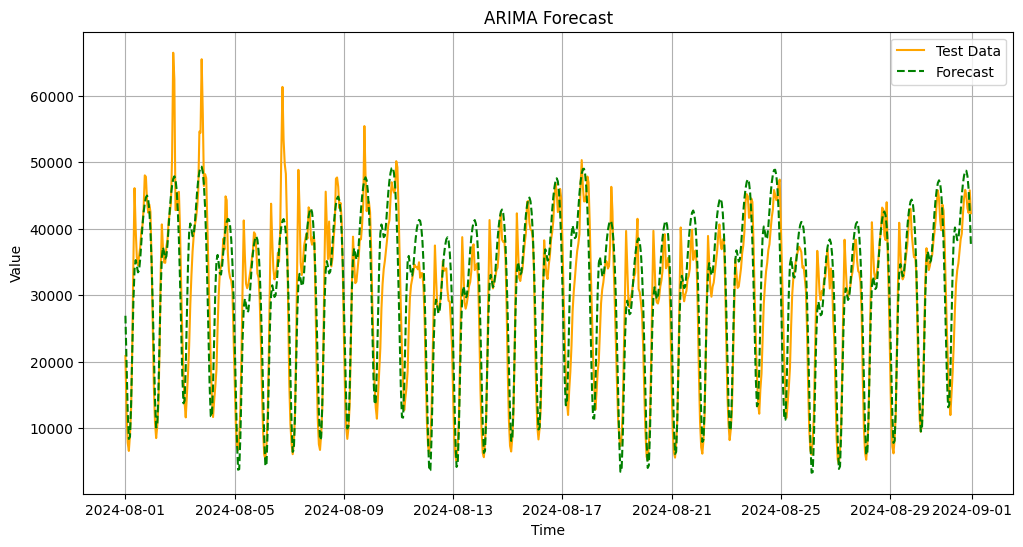

In [10]:
# Plot the results
import matplotlib.pyplot as plt

# Plot the results
plt.figure(figsize=(12, 6))
#plt.plot(df_train[target_col], label='Train Data', color='blue')
plt.plot(df_test[target_col], label='Test Data', color='orange')
plt.plot(df_test[target_col].index, forecast['yhat'], label='Forecast', color='green', linestyle='--')
plt.title('ARIMA Forecast')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.grid()
plt.show()

## Prophet-GARCH

In [12]:
from prophet import Prophet

# Rename the columns to 'ds' (date) and 'y' (target) as required by Prophet
data = data.rename(columns={'num_txns_All': 'y'})  # Replace with your target column
data['ds'] = data.index

train_data = data.loc[:"2024-07-31"]
test_data = data.loc["2024-08-01":]


# Initialize and fit the Prophet model
model = Prophet()
model.fit(train_data)

# Create a dataframe for future dates (test set)
future = test_data[['ds']]  # Prophet requires only the 'ds' column for predictions

# Make predictions
forecast = model.predict(future)

# Model evaluation
print("Train")
prophet_eval_metrics_train = evaluate(test_data['y'], forecast['yhat'])

23:24:55 - cmdstanpy - INFO - Chain [1] start processing
23:25:00 - cmdstanpy - INFO - Chain [1] done processing


Train
MAE: 4278.563397232352
MSE: 30972810.311404064
RMSE: 5565.322121081947
R2: 0.7881385235181536
MAPE: nan



C:\Users\jasiado\AppData\Local\Temp\ipykernel_40432\161732894.py:13: RuntimeWarning: '<' not supported between instances of 'int' and 'Timestamp', sort order is undefined for incomparable objects.
  mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100


# Hyperparameter optimization

In [21]:
import itertools
from tqdm import tqdm

# Define hyperparameter grid
param_grid = {
    'seasonality_mode': ['additive', 'multiplicative'],
    'changepoint_prior_scale': [0.01, 0.1, 0.5],
    'seasonality_prior_scale': [1.0, 10.0, 20.0]
}

# Generate all combinations of hyperparameters
param_combinations = list(itertools.product(
    param_grid['seasonality_mode'],
    param_grid['changepoint_prior_scale'],
    param_grid['seasonality_prior_scale']
))

# Store the evaluation results
results = []

# Loop through each combination of parameters
for params in tqdm(param_combinations):
    seasonality_mode, changepoint_prior_scale, seasonality_prior_scale = params
    
    # Initialize and fit the Prophet model
    model = Prophet(
        seasonality_mode=seasonality_mode,
        changepoint_prior_scale=changepoint_prior_scale,
        seasonality_prior_scale=seasonality_prior_scale
    )
    model.fit(train_data)
    
    # Make predictions
    future = test_data[['ds']]  # Prophet requires only the 'ds' column for predictions
    forecast = model.predict(future)
    
    # Evaluate the model on the test set
    metrics = evaluate(test_data['y'], forecast['yhat'])
    metrics['seasonality_mode'] = seasonality_mode
    metrics['changepoint_prior_scale'] = changepoint_prior_scale
    metrics['seasonality_prior_scale'] = seasonality_prior_scale
    
    # Append the results
    results.append(metrics)

# Convert results to a DataFrame for easier analysis
results_df = pd.DataFrame(results)

# Find the best parameters based on RMSE
best_params = results_df.loc[results_df['RMSE'].idxmin()]

print("Best Parameters:")
print(best_params)

# Refit the model with the best parameters
best_model = Prophet(
    seasonality_mode=best_params['seasonality_mode'],
    changepoint_prior_scale=best_params['changepoint_prior_scale'],
    seasonality_prior_scale=best_params['seasonality_prior_scale']
)
best_model.fit(train_data)

# Make predictions using the best model
final_forecast = best_model.predict(future)

# Model evaluation on test set
final_metrics = evaluate(test_data['y'], final_forecast['yhat'])
print("Final Evaluation Metrics on Test Set:")
print(final_metrics)

  0%|          | 0/18 [00:00<?, ?it/s]23:29:04 - cmdstanpy - INFO - Chain [1] start processing
23:29:08 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\jasiado\AppData\Local\Temp\ipykernel_40432\161732894.py:13: RuntimeWarning: '<' not supported between instances of 'int' and 'Timestamp', sort order is undefined for incomparable objects.
  mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
  6%|▌         | 1/18 [00:05<01:33,  5.50s/it]

MAE: 4558.532955111845
MSE: 33789337.44158673
RMSE: 5812.85966126714
R2: 0.7688728001190738
MAPE: nan



23:29:10 - cmdstanpy - INFO - Chain [1] start processing
23:29:12 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\jasiado\AppData\Local\Temp\ipykernel_40432\161732894.py:13: RuntimeWarning: '<' not supported between instances of 'int' and 'Timestamp', sort order is undefined for incomparable objects.
  mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
 11%|█         | 2/18 [00:09<01:09,  4.37s/it]

MAE: 4560.452185901999
MSE: 33810173.0382804
RMSE: 5814.651583567187
R2: 0.7687302796233707
MAPE: nan



23:29:13 - cmdstanpy - INFO - Chain [1] start processing
23:29:15 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\jasiado\AppData\Local\Temp\ipykernel_40432\161732894.py:13: RuntimeWarning: '<' not supported between instances of 'int' and 'Timestamp', sort order is undefined for incomparable objects.
  mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
 17%|█▋        | 3/18 [00:12<00:59,  3.94s/it]

MAE: 4529.961681741528
MSE: 33473478.501746986
RMSE: 5785.626889261611
R2: 0.7710333512825502
MAPE: nan



23:29:17 - cmdstanpy - INFO - Chain [1] start processing
23:29:22 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\jasiado\AppData\Local\Temp\ipykernel_40432\161732894.py:13: RuntimeWarning: '<' not supported between instances of 'int' and 'Timestamp', sort order is undefined for incomparable objects.
  mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
 22%|██▏       | 4/18 [00:19<01:12,  5.21s/it]

MAE: 4270.3804856307015
MSE: 30900008.33178278
RMSE: 5558.777593300777
R2: 0.7886365065793706
MAPE: nan



23:29:24 - cmdstanpy - INFO - Chain [1] start processing
23:29:30 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\jasiado\AppData\Local\Temp\ipykernel_40432\161732894.py:13: RuntimeWarning: '<' not supported between instances of 'int' and 'Timestamp', sort order is undefined for incomparable objects.
  mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
 28%|██▊       | 5/18 [00:26<01:17,  5.94s/it]

MAE: 4271.290430656176
MSE: 30908099.565412823
RMSE: 5559.505334597029
R2: 0.7885811605940956
MAPE: nan



23:29:31 - cmdstanpy - INFO - Chain [1] start processing
23:29:37 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\jasiado\AppData\Local\Temp\ipykernel_40432\161732894.py:13: RuntimeWarning: '<' not supported between instances of 'int' and 'Timestamp', sort order is undefined for incomparable objects.
  mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
 33%|███▎      | 6/18 [00:34<01:17,  6.47s/it]

MAE: 4270.447737281205
MSE: 30900776.353255324
RMSE: 5558.846674738864
R2: 0.7886312531276655
MAPE: nan



23:29:38 - cmdstanpy - INFO - Chain [1] start processing
23:29:47 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\jasiado\AppData\Local\Temp\ipykernel_40432\161732894.py:13: RuntimeWarning: '<' not supported between instances of 'int' and 'Timestamp', sort order is undefined for incomparable objects.
  mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
 39%|███▉      | 7/18 [00:44<01:24,  7.71s/it]

MAE: 4249.211572594628
MSE: 30712530.533133127
RMSE: 5541.888715332809
R2: 0.789918899840755
MAPE: nan



23:29:51 - cmdstanpy - INFO - Chain [1] start processing
23:29:59 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\jasiado\AppData\Local\Temp\ipykernel_40432\161732894.py:13: RuntimeWarning: '<' not supported between instances of 'int' and 'Timestamp', sort order is undefined for incomparable objects.
  mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
 44%|████▍     | 8/18 [00:57<01:32,  9.24s/it]

MAE: 4247.130252807675
MSE: 30694972.916195296
RMSE: 5540.304406455957
R2: 0.7900389981660458
MAPE: nan



23:30:02 - cmdstanpy - INFO - Chain [1] start processing
23:30:11 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\jasiado\AppData\Local\Temp\ipykernel_40432\161732894.py:13: RuntimeWarning: '<' not supported between instances of 'int' and 'Timestamp', sort order is undefined for incomparable objects.
  mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
 50%|█████     | 9/18 [01:08<01:28,  9.87s/it]

MAE: 4249.737750036401
MSE: 30717091.39086673
RMSE: 5542.300189530221
R2: 0.789887702476236
MAPE: nan



23:30:12 - cmdstanpy - INFO - Chain [1] start processing
23:30:15 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\jasiado\AppData\Local\Temp\ipykernel_40432\161732894.py:13: RuntimeWarning: '<' not supported between instances of 'int' and 'Timestamp', sort order is undefined for incomparable objects.
  mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
 56%|█████▌    | 10/18 [01:12<01:03,  7.98s/it]

MAE: 4377.384645675391
MSE: 31945211.53241632
RMSE: 5652.009512767678
R2: 0.7814870651472432
MAPE: nan



23:30:16 - cmdstanpy - INFO - Chain [1] start processing
23:30:20 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\jasiado\AppData\Local\Temp\ipykernel_40432\161732894.py:13: RuntimeWarning: '<' not supported between instances of 'int' and 'Timestamp', sort order is undefined for incomparable objects.
  mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
 61%|██████    | 11/18 [01:17<00:50,  7.16s/it]

MAE: 4411.22381520519
MSE: 32273459.71028708
RMSE: 5680.973482624882
R2: 0.7792417686140265
MAPE: nan



23:30:22 - cmdstanpy - INFO - Chain [1] start processing
23:30:25 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\jasiado\AppData\Local\Temp\ipykernel_40432\161732894.py:13: RuntimeWarning: '<' not supported between instances of 'int' and 'Timestamp', sort order is undefined for incomparable objects.
  mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
 67%|██████▋   | 12/18 [01:22<00:38,  6.40s/it]

MAE: 4396.57948811608
MSE: 32130094.671264473
RMSE: 5668.341439192286
R2: 0.780222419983335
MAPE: nan



23:30:26 - cmdstanpy - INFO - Chain [1] start processing
23:30:32 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\jasiado\AppData\Local\Temp\ipykernel_40432\161732894.py:13: RuntimeWarning: '<' not supported between instances of 'int' and 'Timestamp', sort order is undefined for incomparable objects.
  mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
 72%|███████▏  | 13/18 [01:29<00:32,  6.59s/it]

MAE: 4107.537313914283
MSE: 29602613.953827336
RMSE: 5440.828425325259
R2: 0.7975109963569961
MAPE: nan



23:30:33 - cmdstanpy - INFO - Chain [1] start processing
23:30:37 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\jasiado\AppData\Local\Temp\ipykernel_40432\161732894.py:13: RuntimeWarning: '<' not supported between instances of 'int' and 'Timestamp', sort order is undefined for incomparable objects.
  mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
 78%|███████▊  | 14/18 [01:34<00:24,  6.24s/it]

MAE: 4107.793082776731
MSE: 29604526.429423712
RMSE: 5441.004174729487
R2: 0.7974979145636583
MAPE: nan



23:30:39 - cmdstanpy - INFO - Chain [1] start processing
23:30:45 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\jasiado\AppData\Local\Temp\ipykernel_40432\161732894.py:13: RuntimeWarning: '<' not supported between instances of 'int' and 'Timestamp', sort order is undefined for incomparable objects.
  mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
 83%|████████▎ | 15/18 [01:42<00:20,  6.72s/it]

MAE: 4110.963150848797
MSE: 29629533.9864525
RMSE: 5443.301754124283
R2: 0.7973268568552342
MAPE: nan



23:30:47 - cmdstanpy - INFO - Chain [1] start processing
23:30:56 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\jasiado\AppData\Local\Temp\ipykernel_40432\161732894.py:13: RuntimeWarning: '<' not supported between instances of 'int' and 'Timestamp', sort order is undefined for incomparable objects.
  mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
 89%|████████▉ | 16/18 [01:54<00:16,  8.19s/it]

MAE: 4098.5818975309585
MSE: 29542661.63576787
RMSE: 5435.316148649301
R2: 0.797921084640716
MAPE: nan



23:30:59 - cmdstanpy - INFO - Chain [1] start processing
23:31:07 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\jasiado\AppData\Local\Temp\ipykernel_40432\161732894.py:13: RuntimeWarning: '<' not supported between instances of 'int' and 'Timestamp', sort order is undefined for incomparable objects.
  mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
 94%|█████████▍| 17/18 [02:04<00:08,  8.93s/it]

MAE: 4096.009818877663
MSE: 29522444.763391238
RMSE: 5433.456060684694
R2: 0.7980593729131877
MAPE: nan



23:31:10 - cmdstanpy - INFO - Chain [1] start processing
23:31:23 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\jasiado\AppData\Local\Temp\ipykernel_40432\161732894.py:13: RuntimeWarning: '<' not supported between instances of 'int' and 'Timestamp', sort order is undefined for incomparable objects.
  mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
100%|██████████| 18/18 [02:20<00:00,  7.81s/it]


MAE: 4095.376907499929
MSE: 29518240.6335213
RMSE: 5433.069172532345
R2: 0.7980881301732687
MAPE: nan

Best Parameters:
MAE                            4095.376907
MSE                        29518240.633521
RMSE                           5433.069173
R2                                0.798088
MAPE                                   NaN
seasonality_mode            multiplicative
changepoint_prior_scale                0.5
seasonality_prior_scale               20.0
Name: 17, dtype: object


23:31:26 - cmdstanpy - INFO - Chain [1] start processing
23:31:39 - cmdstanpy - INFO - Chain [1] done processing


MAE: 4095.376907499929
MSE: 29518240.6335213
RMSE: 5433.069172532345
R2: 0.7980881301732687
MAPE: nan

Final Evaluation Metrics on Test Set:
{'MAE': 4095.376907499929, 'MSE': 29518240.6335213, 'RMSE': 5433.069172532345, 'R2': 0.7980881301732687, 'MAPE': nan}


C:\Users\jasiado\AppData\Local\Temp\ipykernel_40432\161732894.py:13: RuntimeWarning: '<' not supported between instances of 'int' and 'Timestamp', sort order is undefined for incomparable objects.
  mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100


In [22]:
best_params

MAE                            4095.376907
MSE                        29518240.633521
RMSE                           5433.069173
R2                                0.798088
MAPE                                   NaN
seasonality_mode            multiplicative
changepoint_prior_scale                0.5
seasonality_prior_scale               20.0
Name: 17, dtype: object

### Perform GARCH on the residuals
Best hyperparameters used

In [43]:
garch_forecast.mean

,h.01,h.02,h.03,h.04,h.05,h.06,h.07,h.08,h.09,h.10
timestamp_hour,,,,,,,,,,
2024-08-31 23:00:00,-1135.177089,-1135.177089,-1135.177089,-1135.177089,-1135.177089,-1135.177089,-1135.177089,-1135.177089,-1135.177089,-1135.177089


In [44]:
from arch import arch_model
from sklearn.metrics import r2_score

# Extract residuals
test_data['residuals'] = test_data['y'].values - final_forecast['yhat'].values

# Step 3: Fit GARCH model to residuals
garch_model = arch_model(test_data['residuals'].dropna(), vol='Garch', p=1, q=1, rescale=False)
garch_fit = garch_model.fit(disp='off')

# # Step 4: Forecast residual volatility
# garch_forecast = garch_fit.forecast(horizon=5)
# volatility_forecast = garch_forecast.variance[-1:]  # Volatility forecast for next 5 periods


# Step 5: Use Prophet to predict mu (trend/seasonality)
predicted_mu = forecast['yhat']

# Step 6: Use GARCH to predict the residual (et)
garch_forecast = garch_fit.forecast(horizon=10)
predicted_et = garch_forecast.mean['h.01'].iloc[-1]

# Step 7: Combine predictions (yt = mu + et)
prediction = predicted_mu + predicted_et

C:\Users\jasiado\AppData\Local\Temp\ipykernel_40432\2669610947.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['residuals'] = test_data['y'].values - final_forecast['yhat'].values


In [45]:
print("Train")
prophet_eval_metrics_train = evaluate(test_data['y'], prediction)


Train
MAE: 4000.488586863142
MSE: 29261211.23900189
RMSE: 5409.363293309287
R2: 0.7998462730887687
MAPE: nan



C:\Users\jasiado\AppData\Local\Temp\ipykernel_40432\161732894.py:13: RuntimeWarning: '<' not supported between instances of 'int' and 'Timestamp', sort order is undefined for incomparable objects.
  mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
